## Project: Toxic Comments Filter

We will build a model capable of filtering user comments according to the degree of harmfulness of the language:

1. Preprocess the text by eliminating tokens that do not make a significant contribution at the semantic level.
2. Transform the text corpus into sequences.
3. Build a deep learning model with recurrent layers for a multi-label classification task.
4. At prediction time, the model must return a vector containing a 1 or a 0 for each label in the dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). In this way, a non-hazardous comment will be classified by a vector containing only 0s [0,0,0]. Conversely, a dangerous comment will have at least a 1 among the 6 labels.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import spacy
import re
import seaborn as sns
from scipy.stats import shapiro
import string
import warnings
import os
from collections import Counter
from wordcloud import WordCloud
from langdetect import detect, DetectorFactory
import langdetect.lang_detect_exception as lang_detect_exception
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

In [2]:
'''Suppress warnings and TensorFlow logs'''
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

In [3]:
'''Set random seed for reproducibility'''
RANDOM_SEED = 42

In [4]:
'''Load spaCy model'''
nlp = spacy.load('en_core_web_sm')

# EDA

In [5]:
'''Dataset'''
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL + "Filter_Toxic_Comments_dataset.csv")

In [6]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [7]:
df.shape

(159571, 8)

We only need to work with comments in English, but it is possible that there are records in other languages. We will use the langdetect library to detect and delete any comments in other languages.

In [8]:
from langdetect import detect, DetectorFactory
import langdetect.lang_detect_exception as lang_detect_exception

DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except lang_detect_exception.LangDetectException:
        return "unknown"

# Apply language detection function
df['language'] = df['comment_text'].apply(detect_language)

# Filter only comments in English
df_english = df[df['language'] == 'en'].copy()

# Remove language column
df_english.drop(columns=['language'], inplace=True)

In [9]:
df_english.shape

(155283, 8)

The dataset consists of texts and columns indicating whether a text belongs to a particular type of toxic language. A value of 0 indicates that the text is not considered toxic for that category, while a value of 1 indicates that it is. It is possible for a text to be classified in several toxicity categories or none at all.

In [10]:
'''First EDA'''
df_english[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,155283.000000,155283.000000,155283.00000,155283.000000,155283.000000,155283.000000
mean,0.091382,0.008958,0.05007,0.002801,0.046702,0.008063
std,0.288152,0.094221,0.21809,0.052854,0.211000,0.089430
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


Clean comments: 140189 (90.28%)
Bad comments: 15094 (9.72%)


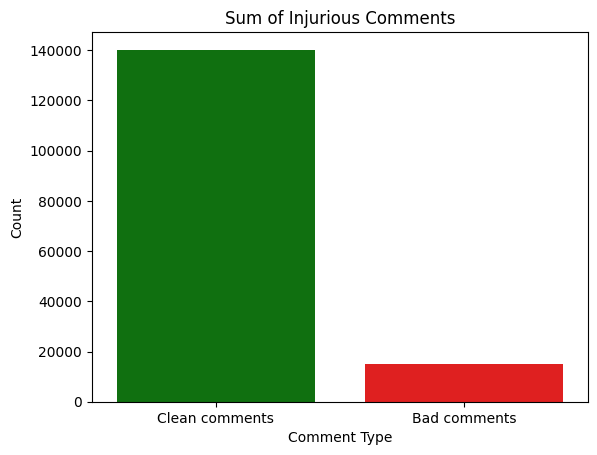

In [11]:
# Calculation of the number of clean and harmful comments
clean_comments = len(df_english[df_english["sum_injurious"] == 0])
bad_comments = len(df_english[df_english["sum_injurious"] != 0])

# percentage calculation
total_comments = clean_comments + bad_comments
clean_comments_percentage = (clean_comments / total_comments) * 100
bad_comments_percentage = (bad_comments / total_comments) * 100

print(f"Clean comments: {clean_comments} ({clean_comments_percentage:.2f}%)")
print(f"Bad comments: {bad_comments} ({bad_comments_percentage:.2f}%)")

data = {
    'Comment Type': ['Clean comments', 'Bad comments'],
    'Count': [clean_comments, bad_comments]
}

df_plot = pd.DataFrame(data)

# Seaborn barplot
sns.barplot(x='Comment Type', y='Count', data=df_plot, palette=['green', 'red'])
plt.title("Sum of Injurious Comments")
plt.xlabel("Comment Type")
plt.ylabel("Count")
plt.show()

In [12]:
df_english[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum()

toxic            14190
severe_toxic      1391
obscene           7775
threat             435
insult            7252
identity_hate     1252
dtype: int64

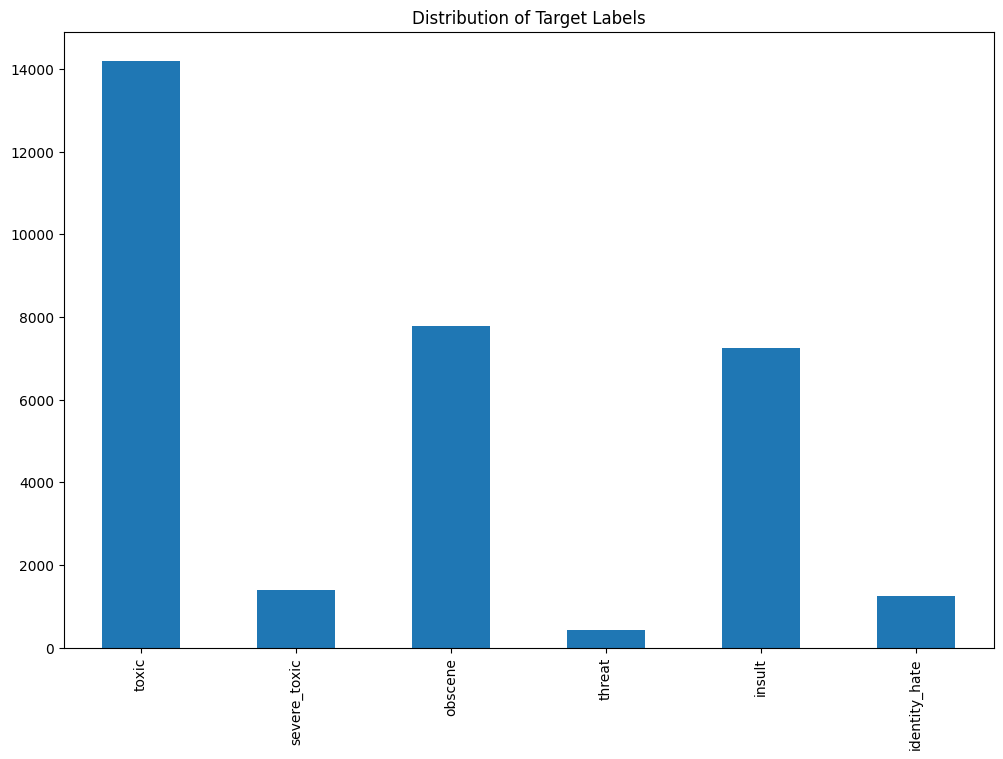

In [13]:
'''Distribution of Target Labels'''

plt.figure(figsize=(12, 8))
df_english[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum().plot(kind='bar')
plt.title('Distribution of Target Labels')
plt.show()

In [14]:
# Counting missing values for each column
missing_values_count = df_english.isna().sum()

print("Missing Values Count for Each Column:")
print(missing_values_count)

Missing Values Count for Each Column:
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
sum_injurious    0
dtype: int64


In [15]:
# Check duplicates
duplicate_rows = df_english.duplicated()
num_duplicates = duplicate_rows.sum()

print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


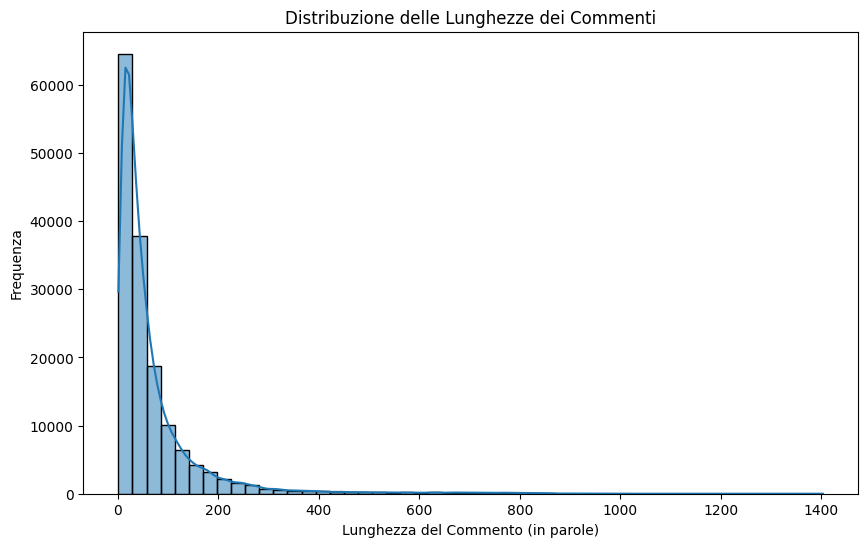

In [16]:
# Calculating the length of comments and saving them in a variable
comment_lengths = df_english['comment_text'].apply(lambda x: len(x.split()))

# Visualisation of the distribution of comment lengths
plt.figure(figsize=(10, 6))
sns.histplot(comment_lengths, bins=50, kde=True)
plt.title('Distribuzione delle Lunghezze dei Commenti')
plt.xlabel('Lunghezza del Commento (in parole)')
plt.ylabel('Frequenza')
plt.show()

The distribution is strongly right-skewed, with most comments less than 200 words in length and a rapidly decreasing frequency of comments.  

In [17]:
# Shapiro-Wilk's test
stat, p_value = shapiro(comment_lengths)

print(f'Shapiro-Wilk Test: Statistics={stat:.3f}, p-value={p_value:.3f}')

alpha = 0.05
if p_value > alpha:
    print('The champion seems Gaussian (cannot be refused H0)')
else:
    print('The champion does not seems Gaussian (refuses H0)')

Shapiro-Wilk Test: Statistics=0.575, p-value=0.000
The champion does not seems Gaussian (refuses H0)


The test suggests a non-normal distribution, given the low p-value calculated. Given the p-value of less than 0.05, we can reject the null hypothesis that the data follow a normal distribution. Therefore, the data are not normally distributed.  

Test statistic (Statistic=0.568): This value is the Shapiro-Wilk test statistic. A value close to 1 indicates that the distribution is normal. In your case, 0.568 is quite far from 1, suggesting that the distribution is not normal.

p-value (p=0.000): The p-value is the probability value associated with the test statistic. In general, a p-value less than 0.05 indicates that we can reject the null hypothesis (that the data follow a normal distribution). In your case, the p-value is significantly less than 0.05, which confirms that the data are not normally distributed.

Most Common Words:
the: 445885
to: 288614
of: 219252
and: 207242
a: 200639
I: 181918
is: 164232
you: 155319
that: 140517
in: 130167
for: 95896
it: 92517
on: 84381
not: 83848
": 80936
be: 80884
this: 71407
have: 69164
as: 68305
are: 65979


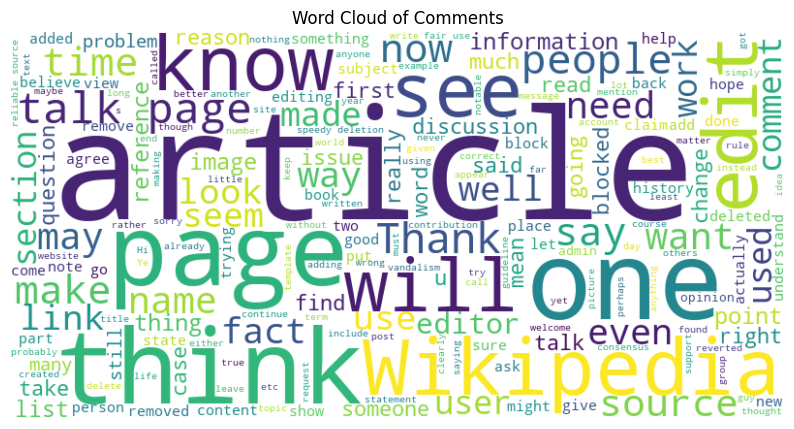

In [18]:
# Combine all comments into a single text
all_text = ' '.join(df_english['comment_text'])

# Count the words
word_counts = Counter(all_text.split())

# Display the most common words
most_common_words = word_counts.most_common(20)
print("Most Common Words:")
for word, count in most_common_words:
    print(f'{word}: {count}')

# Generate a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

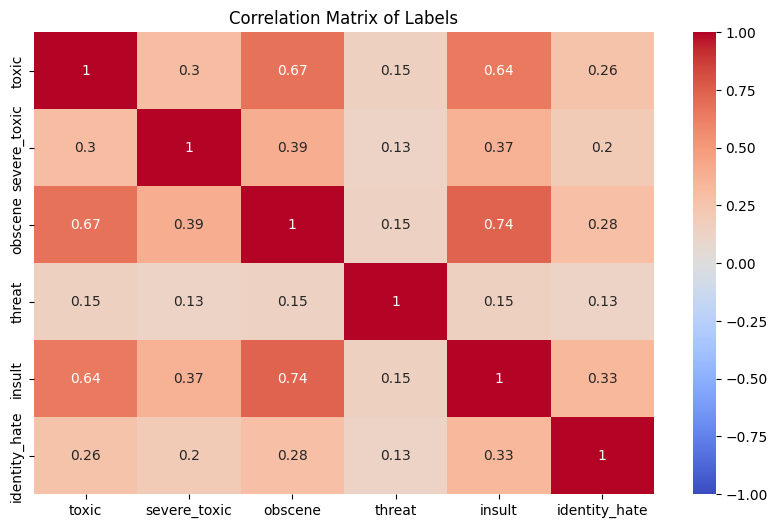

In [19]:
# Calculate the correlation matrix
corr_matrix = df_english[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].corr()

# Display the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Labels')
plt.show()


1. High correlations:

- toxic has a high correlation with obscene (0.68) and insult (0.65).
- obscene has a very high correlation with insult (0.74).
2. Moderate correlations:  

- toxic has a moderate correlation with severe_toxic (0.31).
- severe_toxic has a moderate correlation with obscene (0.4) and insult (0.38).
3. Low correlations:  

- threat generally shows lower correlations with all other labels, e.g. with toxic (0.16) and obscene (0.14).
- identity_hate has low correlations with severe_toxic (0.2) and threat (0.12).
4. Negligible correlations:  

- threat and identity_hate seem to have the lowest correlations with the other labels, indicating that these features might be more distinctive than the others in the dataset.

# Preprocessing

In [20]:
def basic_cleaning(text):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove extra whitespace and new lines
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)  
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    # Remove HTML tags
    text = re.sub(r'<.*?>+', '', text)
    return text

In [22]:
df_final = df_english

In [23]:
# Apply basic cleaning to the entire dataset
df_final['comment_text'] = df_final['comment_text'].apply(basic_cleaning)

In [24]:
df_final.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,explanation why the edits made under my userna...,0,0,0,0,0,0,0
1,daww he matches this background colour im seem...,0,0,0,0,0,0,0
2,hey man im really not trying to edit war its j...,0,0,0,0,0,0,0
3,more i cant make any real suggestions on impro...,0,0,0,0,0,0,0
4,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0


In [25]:
df_final.reset_index(drop=True, inplace=True)

In [26]:
X = df_final.comment_text
X.shape

(155283,)

In [27]:
y = df_final[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
y.shape

(155283, 6)

In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=RANDOM_SEED)

In [29]:
# Function to preprocess and tokenize
def preprocess_and_tokenize(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    processed_text = ' '.join(tokens)
    return processed_text

In [30]:
# Apply preprocessing and tokenization to the training data
X_train = X_train.apply(preprocess_and_tokenize)

In [31]:
X_test = X_test.apply(preprocess_and_tokenize)

In [32]:
# Inizializzazione del tokenizer
from keras_preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [33]:
# Conversione dei testi in sequenze numeriche
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [34]:
maxlen = len(max(X_train_sequences, key=len))

In [35]:
maxlen

1247

In [36]:
vocabulary = len(tokenizer.index_word)+1

In [37]:
vocabulary

176824

In [38]:
# Padding delle sequenze
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen)

In [39]:
# Verifica delle forme delle variabili
print("Shape of X_train_padded:", X_train_padded.shape)
print("Shape of X_test_padded:", X_test_padded.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train_padded: (124226, 1247)
Shape of X_test_padded: (31057, 1247)
Shape of y_train: (124226, 6)
Shape of y_test: (31057, 6)


# Modello

In [40]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [41]:
model = Sequential()

embedding_dim = 100
model.add(Embedding(input_dim=vocabulary, output_dim=embedding_dim, input_length=maxlen))
lstm_units = 64
model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))
num_labels = 6
model.add(Dense(num_labels, activation='sigmoid'))

In [42]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
model.build(input_shape=(None, maxlen))

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1247, 100)      │    17,682,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,725,030 (67.62 MB)

 Trainable params: 17,725,030 (67.62 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Compute class weights
class_weights = []
for i in range(num_labels):
    class_weights.append(compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train.iloc[:, i].values))

In [53]:
# Compute sample weights
sample_weights = np.ones(y_train.shape[0])
for i in range(num_labels):
    sample_weights += y_train.iloc[:, i].values * class_weights[i][1] + (1 - y_train.iloc[:, i].values) * class_weights[i][0]

In [54]:
batch_size = 32
epochs = 5

model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, sample_weight=sample_weights)

Epoch 1/5
3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1010s 289ms/step - accuracy: 0.9347 - loss: 2.0112 - val_accuracy: 0.9932 - val_loss: 1.4872
Epoch 2/5
3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1110s 318ms/step - accuracy: 0.9221 - loss: 1.2721 - val_accuracy: 0.9503 - val_loss: 1.3917
Epoch 3/5
3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1155s 331ms/step - accuracy: 0.8969 - loss: 0.9601 - val_accuracy: 0.9707 - val_loss: 1.4293
Epoch 4/5
3494/3494 ━━━━━━━━━━━━━━━━━━━━ 1040s 298ms/step - accuracy: 0.8208 - loss: 0.7695 - val_accuracy: 0.9430 - val_loss: 1.4415
Epoch 5/5
3494/3494 ━━━━━━━━━━━━━━━━━━━━ 977s 280ms/step - accuracy: 0.8077 - loss: 0.6212 - val_accuracy: 0.8322 - val_loss: 1.6410


In [55]:
predictions = model.predict(X_test_padded)

971/971 ━━━━━━━━━━━━━━━━━━━━ 67s 68ms/step


In [56]:
threshold = 0.5

binary_predictions = (predictions > threshold).astype(int)

In [57]:
# Evaluation metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions, average='weighted')
recall = recall_score(y_test, binary_predictions, average='weighted')
f1 = f1_score(y_test, binary_predictions, average='weighted')
classification_rep = classification_report(y_test, binary_predictions, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.9139
Weighted Precision: 0.7224
Weighted Recall: 0.7308
Weighted F1-Score: 0.7256

Classification Report:
                precision    recall  f1-score   support

        toxic       0.78      0.74      0.76      2865
 severe_toxic       0.43      0.55      0.48       296
      obscene       0.78      0.84      0.81      1565
       threat       0.32      0.41      0.36        91
       insult       0.69      0.71      0.70      1454
identity_hate       0.39      0.41      0.40       262

    micro avg       0.72      0.73      0.72      6533
    macro avg       0.56      0.61      0.58      6533
 weighted avg       0.72      0.73      0.73      6533
  samples avg       0.06      0.06      0.06      6533



In [58]:
predicted_df = pd.DataFrame()

In [59]:
sum_injurious = binary_predictions.sum(axis=1)

In [60]:
min(sum_injurious)

0

In [61]:
max(sum_injurious)

6

In [62]:
predicted_df['comment_text'] = X_test
predicted_df['predicted_toxic'] = binary_predictions[:, 0]
predicted_df['predicted_severe_toxic'] = binary_predictions[:, 1]
predicted_df['predicted_obscene'] = binary_predictions[:, 2]
predicted_df['predicted_threat'] = binary_predictions[:, 3]
predicted_df['predicted_insult'] = binary_predictions[:, 4]
predicted_df['predicted_identity_hate'] = binary_predictions[:, 5]
predicted_df['sum_injurious'] = sum_injurious

In [63]:
predicted_df.head(20)

,comment_text,predicted_toxic,predicted_severe_toxic,predicted_obscene,predicted_threat,predicted_insult,predicted_identity_hate,sum_injurious
84461,final note melee mouthed internet addict mutat...,1,0,1,0,1,0,3
75374,oh person attitudeagenda huh poke medrs urethr...,1,0,0,0,0,0,1
1068,sail labs technology tell delete entire page s...,0,0,0,0,0,0,0
137354,not try pad template useful document helpwikim...,0,0,0,0,0,0,0
1045,kitten love artical,0,0,0,0,0,0,0
148653,forgot log username correct mistake address ma...,1,0,1,0,0,0,2
1078,long today restore templateverylong page lengt...,0,0,0,0,0,0,0
101663,satanism satanism consider christian sect draw...,0,0,0,0,0,0,0
45892,mod problem user page list pagesuser block art...,1,0,1,0,0,0,2
47844,source faith mental health religious resource ...,0,0,0,0,0,0,0


---